# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, MultiStepLR

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import keras
from keras.layers import Input, Flatten, Dense, LeakyReLU, Dropout
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras import backend as K
from keras.models import clone_model
from keras import Model
from keras.datasets import mnist
from keras.utils import np_utils

import tensorflow.compat.v1 as tf
from tensorflow.keras import regularizers
from tensorflow.keras import initializers

import numpy as np
import collections
import copy
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.optimize as op 
import seaborn as sns

import pickle

### Sample Utility

In [2]:
# utility_func_args = [x_train, y_train, x_val, y_val]
def sample_utility(n, size_min, size_max, utility_func, utility_func_args, random_state, ub_prob=0.2, verbose=False):

  x_train, y_train, x_val, y_val = utility_func_args

  X_feature_test = []
  y_feature_test = []

  x_train = np.array(x_train)
  y_train = np.array(y_train)

  N = len(y_train)

  np.random.seed(random_state)
  
  for i in range(n):
    if verbose:
      print('{} / {}'.format(i, n))

    n_select = np.random.choice(range(size_min, size_max))

    subset_index = []

    """
    if unbalance:
      n_per_class = int(N / 10)
      alpha = np.ones(10)
      alpha[np.random.choice(range(10))] = np.random.choice(range(1, 50))
    else:
      alpha = np.random.choice(range(1, 20), size=10, replace=True)
    """

    toss = np.random.uniform()

    # With probability ub_prob, sample a class-imbalanced subset
    if toss > 1-ub_prob:
      n_per_class = int(N / 10)
      alpha = np.ones(10)
      alpha[np.random.choice(range(10))] = np.random.choice(range(1, 50))
    else:
      alpha = np.random.choice(range(90, 100), size=10, replace=True)

    p = np.random.dirichlet(alpha=alpha)
    occur = np.random.choice(range(10), size=n_select, replace=True, p=p)
    counts = np.array([np.sum(occur==i) for i in range(10)])
    
    for i in range(10):
      ind_i = np.where(np.argmax(y_train, 1)==i)[0]
      if len(ind_i) > counts[i]:
        selected_ind_i = np.random.choice(ind_i, size=counts[i], replace=False)
      else:
        selected_ind_i = np.random.choice(ind_i, size=counts[i], replace=True)
      subset_index = subset_index + list(selected_ind_i)

    subset_index = np.array(subset_index)

    y_feature_test.append(utility_func(x_train[subset_index], y_train[subset_index], x_val, y_val))
    X_feature_test.append( subset_index )

  return X_feature_test, y_feature_test


def sample_utility_veryub(n, size_min, size_max, utility_func, utility_func_args, random_state, ub_prob=0.2, verbose=False):

  x_train, y_train, x_val, y_val = utility_func_args

  X_feature_test = []
  y_feature_test = []

  x_train = np.array(x_train)
  y_train = np.array(y_train)

  N = len(y_train)

  np.random.seed(random_state)
  
  for i in range(n):
    if verbose:
      print('{} / {}'.format(i, n))

    n_select = np.random.choice(range(size_min, size_max))

    if n_select > 0:
      subset_index = []

      toss = np.random.uniform()

      # With probability ub_prob, sample a class-imbalanced subset
      if toss > 1-ub_prob:
        alpha = np.random.choice(range(1, 100), size=10, replace=True)
      else:
        alpha = np.random.choice(range(90, 100), size=10, replace=True)

      p = np.random.dirichlet(alpha=alpha)
      occur = np.random.choice(range(10), size=n_select, replace=True, p=p)
      counts = np.array([np.sum(occur==i) for i in range(10)])
      
      for i in range(10):
        ind_i = np.where(np.argmax(y_train, 1)==i)[0]
        if len(ind_i) > counts[i]:
          selected_ind_i = np.random.choice(ind_i, size=counts[i], replace=False)
        else:
          selected_ind_i = np.random.choice(ind_i, size=counts[i], replace=True)
        subset_index = subset_index + list(selected_ind_i)

      subset_index = np.array(subset_index)

      y_feature_test.append(utility_func(x_train[subset_index], y_train[subset_index], x_val, y_val))
      X_feature_test.append( subset_index )
    else:
      y_feature_test.append(0.1)
      X_feature_test.append( np.array([]) )

  return X_feature_test, y_feature_test

### Deep Sets

In [3]:
class DeepSet(nn.Module):

    def __init__(self, in_features, set_features=128, hidden_ext=128, hidden_reg=128):
        super(DeepSet, self).__init__()
        self.in_features = in_features
        self.out_features = set_features
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_features, hidden_ext, bias=False),
            nn.ELU(inplace=True),
            nn.Linear(hidden_ext, hidden_ext, bias=False),
            nn.ELU(inplace=True),
            nn.Linear(hidden_ext, set_features, bias=False)
        )

        self.regressor = nn.Sequential(
            nn.Linear(set_features, hidden_reg, bias=False),
            nn.ELU(inplace=True),
            nn.Linear(hidden_reg, hidden_reg, bias=False),
            nn.ELU(inplace=True),
            nn.Linear(hidden_reg, int(hidden_reg/2), bias=False),
            nn.ELU(inplace=True)
        )

        self.linear = nn.Linear(int(hidden_reg/2), 1)
        self.sigmoid = nn.Sigmoid()
        
        self.add_module('0', self.feature_extractor)
        self.add_module('1', self.regressor)
        
    def reset_parameters(self):
        for module in self.children():
            reset_op = getattr(module, "reset_parameters", None)
            if callable(reset_op):
                reset_op()
            
    def forward(self, input):
        x = input
        x = self.feature_extractor(x)
        x = x.sum(dim=1)
        x = self.regressor(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'Feature Exctractor=' + str(self.feature_extractor) \
            + '\n Set Feature' + str(self.regressor) + ')'


class DeepSet_cifar(nn.Module):

    def __init__(self, in_features, set_features=512):
        super(DeepSet_cifar, self).__init__()
        self.in_features = in_features
        self.out_features = set_features
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ELU(inplace=True),
            nn.Linear(512, 512),
            nn.ELU(inplace=True),
            nn.Linear(512, set_features)
        )

        self.regressor = nn.Sequential(
            nn.Linear(set_features, 512),
            nn.ELU(inplace=True),
            nn.Linear(512, 512),
            nn.ELU(inplace=True),
            nn.Linear(512, 512),
            nn.ELU(inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
        self.add_module('0', self.feature_extractor)
        self.add_module('1', self.regressor)
        
        
    def reset_parameters(self):
        for module in self.children():
            reset_op = getattr(module, "reset_parameters", None)
            if callable(reset_op):
                reset_op()
            
    def forward(self, input):
        x = input
        x = self.feature_extractor(x)
        x = x.sum(dim=1)
        x = self.regressor(x)
        return x

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'Feature Exctractor=' + str(self.feature_extractor) \
            + '\n Set Feature' + str(self.regressor) + ')'

### Deepset Utility Learning Model

In [4]:
class Utility_deepset(object):

    def __init__(self, model=None):

        """
        if model is None:
          self.model = DeepSet(in_dims).cuda()
        else:
          self.model = model.cuda()
        """

        self.model = model

        self.model.linear.bias = torch.nn.Parameter(torch.tensor([-2.1972]))
        self.model.linear.bias.requires_grad = False
        #print(self.model.linear.bias)
        self.model.cuda()
        #print(self.model.linear.bias)
        
        self.l1 = nn.L1Loss()
        self.l2 = nn.MSELoss(reduction='sum')
        
    # train_data: x_train_few
    # train_set: (X_feature, y_feature)
    # valid_set: (X_feature_test, y_feature_test)
    def fit(self, train_data, train_set, valid_set, n_epoch, batch_size=32, lr=1e-3):

        self.optim = optim.Adam(self.model.parameters(), lr)

        #scheduler = StepLR(self.optim, step_size=10, gamma=0.1)
        scheduler = MultiStepLR(self.optim, milestones=[10,15], gamma=0.1)

        train_data = copy.deepcopy(train_data)
        N = train_data.shape[0]
        k = train_data.shape[1]

        X_feature, y_feature = train_set
        X_feature_test, y_feature_test = valid_set
        train_size = len(y_feature)

        for epoch in range(n_epoch):

          # Shuffle training utility samples
          ind = np.arange(train_size, dtype=int)
          np.random.shuffle(ind)
          X_feature = [X_feature[i] for i in ind]
          y_feature = y_feature[ind]

          train_loss = 0
          start_ind = 0

          for j in range(train_size//batch_size):
            start_ind = j*batch_size
            batch_X, batch_y = [], []
            for i in range(start_ind, min(start_ind+batch_size, train_size)):

              b = np.zeros((N, k))
              if len(X_feature[i]) > 0:
                selected_train_data = train_data[X_feature[i]]
                b[:len(X_feature[i])] = selected_train_data

              batch_X.append( b )
              batch_y.append( [y_feature[i]] )

            batch_X = np.stack(batch_X)
            batch_X, batch_y = torch.FloatTensor(batch_X).cuda(), torch.FloatTensor(batch_y).cuda()

            self.optim.zero_grad()
            y_pred = self.model(batch_X)
            loss = self.l2(y_pred, batch_y)
            loss_val = np.asscalar(loss.data.cpu().numpy())
            loss.backward()
            self.optim.step()
            train_loss += loss_val
          train_loss /= train_size
          test_loss = self.evaluate(train_data, valid_set)
          scheduler.step()
          print('Epoch %s Train Loss %s Test Loss %s' % (epoch, train_loss, test_loss))
          # print(self.model.linear.bias)
    
    def evaluate(self, train_data, valid_set):

        N, k = train_data.shape
        X_feature_test, y_feature_test = valid_set

        test_size = len(y_feature_test)
        test_loss = 0

        for i in range(test_size):

            b = np.zeros((N, k))
            if len(X_feature_test[i]) > 0:
              selected_train_data = train_data[X_feature_test[i]]
              b[:len(X_feature_test[i])] = selected_train_data

            batch_X, batch_y = torch.FloatTensor(b).cuda(), torch.FloatTensor(y_feature_test[i:i+1]).cuda()
            batch_X, batch_y = batch_X.reshape((1, N, k)), batch_y.reshape((1, 1))
            y_pred = self.model(batch_X)

            loss = self.l2(y_pred, batch_y)
            loss_val = np.asscalar(loss.data.cpu().numpy())
            test_loss += loss_val
        test_loss /= test_size
        return test_loss


def array_to_lst(X_feature):

  if type(X_feature) == list:
    return X_feature

  X_feature = list(X_feature)
  for i in range(len(X_feature)):
    X_feature[i] = X_feature[i].nonzero()[0]
  return X_feature


def findMostValuableSample_deepset_greedy(model, unlabeled_set, target_size):

  model = model.cuda()

  N, input_dim = unlabeled_set.shape
  k = target_size

  selected_subset = np.zeros(N)
  selected_rank = []
  selected_data = np.zeros((N, input_dim))

  for i in range(k):
    print(i)
    maxIndex, maxVal = -1, -1
    prevUtility = model(torch.FloatTensor(selected_data.reshape((1, N, input_dim))).cuda())
    searchRange = np.where(selected_subset == 0)[0]
    for j in searchRange:
      selected_subset[j] = 1
      selected_data[j] = unlabeled_set[j]
      utility = model(torch.FloatTensor(selected_data.reshape((1, N, input_dim))).cuda())
      selected_subset[j] = 0
      selected_data[j] = np.zeros(input_dim)
      if utility - prevUtility > maxVal:
        maxIndex = j
        maxVal = utility - prevUtility
    selected_subset[maxIndex] = 1
    selected_rank.append(maxIndex)
    selected_data[maxIndex] = unlabeled_set[maxIndex]

  return selected_subset, selected_rank, selected_data


def findMostValuableSample_deepset_stochasticgreedy(model, unlabeled_set, target_size, epsilon, seed, verbose=False, debug=False, label=None):

  model = model.cuda()

  N, input_dim = unlabeled_set.shape
  k = target_size

  selected_subset = np.zeros(N)
  selected_rank = []

  R = int((N/k)*np.log(1/epsilon))
  
  print('Sample Size R={}'.format(R))

  if debug:
    R = 10
    print('Sample Size R={}'.format(R))

  np.random.seed(seed)
  selected_data = np.zeros((N, input_dim))

  for i in range(k):
    if verbose: print(i)
    
    maxIndex, maxVal = -1, -1

    prevUtility = model(torch.FloatTensor(selected_data.reshape((1, N, input_dim))).cuda())
    searchRange = np.where(selected_subset == 0)[0]

    if debug:
      print('Step {}, prevUtility={}'.format(i, prevUtility))

    if R < len(searchRange):
      searchRange = np.random.choice(searchRange, size=R, replace=False)

    for j in searchRange:
      selected_subset[j] = 1
      selected_data[j] = unlabeled_set[j]
      utility = model(torch.FloatTensor(selected_data.reshape((1, N, input_dim))).cuda())
      selected_subset[j] = 0
      selected_data[j] = np.zeros(input_dim)
      gain = (utility - prevUtility).cpu().detach().numpy()[0][0]

      if gain > maxVal:
        maxIndex = j
        maxVal = gain

      if debug:
        print('  Gain from {} is {}, label={}'.format(j, gain, label[j]))
        print('  maxIndex={}, maxVal={}, labelMaxIndex={}'.format(maxIndex, maxVal, label[maxIndex]))
      
    selected_subset[maxIndex] = 1
    selected_rank.append(maxIndex)
    selected_data[maxIndex] = unlabeled_set[maxIndex]

  return selected_subset, selected_rank, selected_data

### FASS

In [5]:
class PyTorchFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.flatten = PyTorchFlatten()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        torch.nn.init.xavier_uniform(self.linear.weight)
        torch.nn.init.zeros_(self.linear.bias)

    def forward(self, x, last=False):
        x = self.flatten(x)
        outputs = self.linear(x)
        if last:
            return outputs, x
        else:
            return outputs

    def get_embedding_dim(self):
        return 28*28


class MnistLeNet(torch.nn.Module):
    def __init__(self):
        super(MnistLeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding_mode='replicate')
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.linear1 = nn.Linear(in_features=2880, out_features=500)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(in_features=500, out_features=10)

        torch.nn.init.xavier_uniform(self.conv1.weight)
        torch.nn.init.zeros_(self.conv1.bias)

        torch.nn.init.xavier_uniform(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)

        torch.nn.init.xavier_uniform(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)

    def forward(self, x, last=False):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = torch.flatten(x, 1)
        x = self.relu(self.linear1(x))
        logits = self.linear2(x)
        outputs = F.softmax(logits, dim=1)

        if last:
            return outputs, x
        else:
            return outputs

    def get_embedding_dim(self):
        return 500

from torch.utils.data import Dataset, DataLoader, TensorDataset

def torch_mnist_logistic_data_to_acc(x_train, y_train, verbose=0):

  criterion = torch.nn.CrossEntropyLoss()
  net = LogisticRegression(28*28, 10)
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-7)

  tensor_x, tensor_y = torch.Tensor(x_train), torch.Tensor(y_train)
  fewshot_dataset = TensorDataset(tensor_x,tensor_y)
  train_loader = DataLoader(dataset=fewshot_dataset, batch_size=32, shuffle=True)
  tensor_x_test, tensor_y_test = torch.Tensor(x_test), torch.Tensor(y_test)
  test_dataset = TensorDataset(tensor_x_test,tensor_y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

  for epoch in range(5):
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images.view(-1, 28 * 28))
          labels = Variable(labels)
          labels = torch.argmax(labels, dim=1)
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = Variable(images.view(-1, 28*28))
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          labels = torch.argmax(labels, dim=1)
          correct += (predicted == labels).sum()
      accuracy = 100 * correct/total
      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
  print('Model Accuracy: {}'.format(accuracy))
  return net

## Add Gaussian Noise

In [6]:
from google.colab.patches import cv2_imshow

def addGaussianNoise(x_train, scale=1):
  return np.clip(x_train+np.random.normal(scale=scale, size=x_train.shape), 0, 1)

ModuleNotFoundError: No module named 'google.colab'

## cyCADA

In [7]:
import torch
import torch.nn as nn
from torch.nn import init
import numpy as np
import torchvision

models = {}
def register_model(name):
    def decorator(cls):
        models[name] = cls
        return cls
    return decorator

def get_model(name, num_cls=10, **args):
    net = models[name](num_cls=num_cls, **args)
    if torch.cuda.is_available():
        net = net.cuda()
    return net

"""
def init_weights(obj):
    for m in obj.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            init.xavier_normal_(m.weight)
            print(m)
            m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.reset_parameters()
"""

def init_weights(obj):
    for m in obj.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            init.xavier_normal_(m.weight)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.reset_parameters()

class TaskNet(nn.Module):

    num_channels = 3
    image_size = 32
    name = 'TaskNet'

    "Basic class which does classification."
    def __init__(self, num_cls=10, weights_init=None):
        super(TaskNet, self).__init__()
        self.num_cls = num_cls
        self.setup_net()
        self.criterion = nn.CrossEntropyLoss()
        if weights_init is not None:
            self.load(weights_init)
        else:
            # import pdb;pdb.set_trace()
            init_weights(self)

    def forward(self, x, with_ft=False):
        x = self.conv_params(x) #NOTE input x shape: bs* 1* image_size*image_size
        x = x.view(x.size(0), -1)
        # import pdb; pdb.set_trace()
        x = self.fc_params(x)
        score = self.classifier(x) # bs * num_cls
        if with_ft:
            return score, x
        else:
            return score

    def setup_net(self):
        """Method to be implemented in each class."""
        pass

    def load(self, init_path):
        net_init_dict = torch.load(init_path)
        self.load_state_dict(net_init_dict)

    def save(self, out_path):
        torch.save(self.state_dict(), out_path)
    
    def get_embedding_dim(self):
        return 512
    



@register_model('resnet18')
class ResNetClassifier(TaskNet):
    "Classifier used for VisDA2017 Experiment"

    num_channels = 3
    image_size = 32
    name = 'resnet18'
    out_dim = 512  # dim of last feature layer
    
    def get_embedding_dim(self):
        return out_dim
    
    def setup_net(self):
        model_resnet18 = torchvision.models.resnet18(pretrained=True)
        # pdb.set_trace()
        layers = [
                model_resnet18.conv1, 
                model_resnet18.bn1, 
                model_resnet18.relu,
                model_resnet18.maxpool,
                model_resnet18.layer1,
                model_resnet18.layer2,
                model_resnet18.layer3, # 1024
                model_resnet18.layer4, # 
                model_resnet18.avgpool
                ]

        self.conv_params = nn.Sequential(*layers)

        self.fc_params = nn.Sequential (
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                )

        self.classifier = nn.Sequential(
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(512, self.num_cls)
                )
        self.get_embedding_dim = 512



@register_model('AddaNet')
class AddaNet(nn.Module):
    "Defines and Adda Network."
    def __init__(self, num_cls=10, model='LeNet', src_weights_init=None,
            weights_init=None):
        super(AddaNet, self).__init__()
        self.name = 'AddaNet'
        self.base_model = model
        self.num_cls = num_cls
        self.cls_criterion = nn.CrossEntropyLoss()
        self.gan_criterion = nn.CrossEntropyLoss()
      
        self.setup_net()
        if weights_init is not None:
            self.load(weights_init)
        elif src_weights_init is not None:
            self.load_src_net(src_weights_init)
        else:
            raise Exception('AddaNet must be initialized with weights.')
        

    def forward(self, x_s, x_t):
        """Pass source and target images through their
        respective networks."""
        score_s, x_s = self.src_net(x_s, with_ft=True)
        score_t, x_t = self.tgt_net(x_t, with_ft=True)

        if self.discrim_feat:
            d_s = self.discriminator(x_s)
            d_t = self.discriminator(x_t)
        else:
            d_s = self.discriminator(score_s)
            d_t = self.discriminator(score_t)
        return score_s, score_t, d_s, d_t

    def setup_net(self):
        """Setup source, target and discriminator networks."""
        self.src_net = get_model(self.base_model, num_cls=self.num_cls)
        self.tgt_net = get_model(self.base_model, num_cls=self.num_cls)

        input_dim = self.num_cls 
        self.discriminator = nn.Sequential(
                nn.Linear(input_dim, 500),
                nn.ReLU(),
                nn.Linear(500, 500),
                nn.ReLU(),
                nn.Linear(500, 2),
                )

        self.image_size = self.src_net.image_size
        self.num_channels = self.src_net.num_channels

    def load(self, init_path):
        "Loads full src and tgt models."
        net_init_dict = torch.load(init_path)
        self.load_state_dict(net_init_dict)

    def load_src_net(self, init_path):
        """Initialize source and target with source
        weights."""
        self.src_net.load(init_path)
        self.tgt_net.load(init_path)

    def save(self, out_path):
        torch.save(self.state_dict(), out_path)

    def save_tgt_net(self, out_path):
        torch.save(self.tgt_net.state_dict(), out_path)

## AFN

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.autograd import Variable
import torch.nn.functional as F
import math


class ResBase101(nn.Module):
    def __init__(self):
        super(ResBase101, self).__init__()
        model_resnet101 = torchvision.models.resnet101(pretrained=True)
        self.conv1 = model_resnet101.conv1
        self.bn1 = model_resnet101.bn1
        self.relu = model_resnet101.relu
        self.maxpool = model_resnet101.maxpool
        self.layer1 = model_resnet101.layer1
        self.layer2 = model_resnet101.layer2
        self.layer3 = model_resnet101.layer3
        self.layer4 = model_resnet101.layer4
        self.avgpool = model_resnet101.avgpool

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class ResBase50(nn.Module):
    def __init__(self):
        super(ResBase50, self).__init__()
        model_resnet50 = models.resnet50(pretrained=True)
        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool
        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4
        self.avgpool = model_resnet50.avgpool

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class ResClassifier(nn.Module):
    def __init__(self, class_num=12, extract=False):
        super(ResClassifier, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(2048, 1000),
            nn.BatchNorm1d(1000, affine=True),
            nn.ReLU(inplace=True),
            nn.Dropout()
            )
        self.fc2 = nn.Sequential(
            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000, affine=True),
            nn.ReLU(inplace=True),
            nn.Dropout()
            )
        self.fc3 = nn.Linear(1000, class_num)
        self.extract = extract

    def forward(self, x):
        fc1_emb = self.fc1(x)
        if self.training:
            fc1_emb.mul_(math.sqrt(0.5))
        fc2_emb = self.fc2(fc1_emb)
        if self.training:
            fc2_emb.mul_(math.sqrt(0.5))            
        logit = self.fc3(fc2_emb)

        if self.extract:
            return fc2_emb, logit
        return logit

class ResBase18(nn.Module):
    def __init__(self):
        super(ResBase18, self).__init__()
        model_resnet18 = models.resnet18(pretrained=True)
        self.conv1 = model_resnet18.conv1
        self.bn1 = model_resnet18.bn1
        self.relu = model_resnet18.relu
        self.maxpool = model_resnet18.maxpool
        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3 # 1024
        # self.layer4 = model_resnet18.layer4
        # self.avgpool = model_resnet18.avgpool

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

'''
class ResClassifier(nn.Module):
    def __init__(self, class_num=12, extract=False):
        super(ResClassifier, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512, affine=True),
            nn.ReLU(inplace=True),
            nn.Dropout()
            )
        self.fc3 = nn.Linear(512, class_num)
        self.extract = extract

    def forward(self, x):
        fc1_emb = self.fc1(x)
        if self.training:
            fc1_emb.mul_(math.sqrt(0.5))
        # fc2_emb = self.fc2(fc1_emb)
        # if self.training:
        #     fc2_emb.mul_(math.sqrt(0.5))            
        logit = self.fc3(fc1_emb)

        if self.extract:
            return fc1_emb, logit
        return logit
'''

'\nclass ResClassifier(nn.Module):\n    def __init__(self, class_num=12, extract=False):\n        super(ResClassifier, self).__init__()\n        self.fc1 = nn.Sequential(\n            nn.Linear(1024, 512),\n            nn.BatchNorm1d(512, affine=True),\n            nn.ReLU(inplace=True),\n            nn.Dropout()\n            )\n        self.fc3 = nn.Linear(512, class_num)\n        self.extract = extract\n\n    def forward(self, x):\n        fc1_emb = self.fc1(x)\n        if self.training:\n            fc1_emb.mul_(math.sqrt(0.5))\n        # fc2_emb = self.fc2(fc1_emb)\n        # if self.training:\n        #     fc2_emb.mul_(math.sqrt(0.5))            \n        logit = self.fc3(fc1_emb)\n\n        if self.extract:\n            return fc1_emb, logit\n        return logit\n'

## Image Preprocess

In [9]:
def cifar_encoderProcess(x_train, y_train, x_test, y_test):

  N_train = len(y_train)
  N_test = len(y_test)


  # x_train = x_train.astype(np.float32)
  # x_test = x_test.astype(np.float32)
  # x_train = np.moveaxis(x_train, 1, 3)
  # x_test = np.moveaxis(x_test, 1, 3)

  x_train = torch.from_numpy(x_train)
  x_test = torch.from_numpy(x_test) # tensor of shape 3, 32, 32
  
  x_transfer = transforms.Compose([
                      transforms.ToPILImage(), #Tensor of shape C x H x W or a numpy ndarray of shape H x W x C
                      transforms.ToTensor(),
                      # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2430, 0.2610))
                      ])

  x_train_r = []
  for i in range(x_train.shape[0]):
    # import pdb; pdb.set_trace()
    x_r = x_transfer(x_train[i])
    x_train_r.append(x_r)

  b = torch.Tensor(N_train, 3, 32, 32)
  x_train_r = torch.cat(x_train_r, out=b)
  x_train_r = x_train_r.reshape(N_train, 3, 32, 32)

  x_test_r = []
  for i in range(x_test.shape[0]):
    x_r = x_transfer(x_test[i])
    x_test_r.append(x_r)

  b = torch.Tensor(N_test, 3, 32, 32)
  x_test_r = torch.cat(x_test_r, out=b)
  x_test_r = x_test_r.reshape(N_test, 3, 32, 32)

  y_train = torch.Tensor(y_train).long()
  y_test = torch.Tensor(y_test).long()

  return x_train_r, y_train, x_test_r, y_test

### VISDA

In [10]:
from torchvision import transforms

def visda_encoder_process(x_train, y_train, x_test, y_test):
  
  N_train = len(y_train)
  N_test = len(y_test)

  x_transfer = transforms.Compose([
                      transforms.ToPILImage(), #Tensor of shape C x H x W or a numpy ndarray of shape H x W x C
                      transforms.Resize((32, 32)),
                      transforms.ToTensor(),
                      ])

  x_train_r = []
  for i in range(x_train.shape[0]):
    # import pdb; pdb.set_trace()
    x_r = x_transfer(x_train[i])
    x_train_r.append(x_r)

  b = torch.Tensor(N_train, 3, 32, 32)
  x_train_r = torch.cat(x_train_r, out=b)
  x_train_r = x_train_r.reshape(N_train, 3, 32, 32)

  x_test_r = []
  for i in range(x_test.shape[0]):
    x_r = x_transfer(x_test[i])
    x_test_r.append(x_r)

  b = torch.Tensor(N_test, 3, 32, 32)
  x_test_r = torch.cat(x_test_r, out=b)
  x_test_r = x_test_r.reshape(N_test, 3, 32, 32)

  # y_train = torch.Tensor(y_train).long()
  # y_test = torch.Tensor(y_test).long()

  return x_train_r, y_train, x_test_r, y_test
  

In [13]:
sample_dir = prefix + '/active-learning-transfer/samples/visda'
# x_train_few_re, y_train_few_re, x_val_few_re, y_val_few_re = pickle.load(open(sample_dir + '/visda_src_500.data', 'rb'))

In [ ]:
print(x_train_few_re.shape)

NameError: ignored

### VISDA data to acc

In [14]:
def torch_visda_resnet_data_to_acc(x_train, y_train, x_test, y_test, verbose=0):

  criterion = torch.nn.CrossEntropyLoss()
  net = ResNetClassifier(num_cls=12).cuda()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-7)

  tensor_x, tensor_y = torch.Tensor(x_train).cuda(), torch.Tensor(y_train).cuda()
  fewshot_dataset = TensorDataset(tensor_x,tensor_y)
  train_loader = DataLoader(dataset=fewshot_dataset, batch_size=64, shuffle=True, drop_last=True)
  tensor_x_test, tensor_y_test = torch.Tensor(x_test).cuda(), torch.Tensor(y_test).cuda()
  test_dataset = TensorDataset(tensor_x_test,tensor_y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, drop_last=True)

  for epoch in range(20):
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images)
          labels = Variable(labels).long()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = Variable(images)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
      accuracy = 100 * correct/total
      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
  return accuracy.item()



def torch_visda_resnet_data_to_acc_multiple(X_train, y_train, x_val, y_val, repeat=3, verbose=0):
  acc_lst = []
  for _ in range(repeat):
    acc = torch_visda_resnet_data_to_acc(X_train, y_train, x_val, y_val, verbose)
    acc_lst.append(acc)
  return np.mean(acc_lst)


def torch_visda_resnet_data_to_net(x_train, y_train, x_test, y_test, n_epoch=10, verbose=0):

  criterion = torch.nn.CrossEntropyLoss()
  net = ResNetClassifier(num_cls=12).cuda()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-7)

  tensor_x, tensor_y = torch.Tensor(x_train).cuda(), torch.Tensor(y_train).cuda()
  fewshot_dataset = TensorDataset(tensor_x,tensor_y)
  train_loader = DataLoader(dataset=fewshot_dataset, batch_size=64, shuffle=True)
  tensor_x_test, tensor_y_test = torch.Tensor(x_test).cuda(), torch.Tensor(y_test).cuda()
  test_dataset = TensorDataset(tensor_x_test,tensor_y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

  for epoch in range(n_epoch):
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images)
          labels = Variable(labels).long()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = Variable(images)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
      accuracy = 100 * correct/total
      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
  return net

In [15]:
def torch_visda_resnet101_data_to_acc(x_train, y_train, x_test, y_test, verbose=0):

  criterion = torch.nn.CrossEntropyLoss()

  netG = ResBase101().cuda()
  netF = ResClassifier(class_num=12, extract=True).cuda()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-7)

  tensor_x, tensor_y = torch.Tensor(x_train).cuda(), torch.Tensor(y_train).cuda()
  fewshot_dataset = TensorDataset(tensor_x,tensor_y)
  train_loader = DataLoader(dataset=fewshot_dataset, batch_size=64, shuffle=True, drop_last=True)
  tensor_x_test, tensor_y_test = torch.Tensor(x_test).cuda(), torch.Tensor(y_test).cuda()
  test_dataset = TensorDataset(tensor_x_test,tensor_y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, drop_last=True)

  for epoch in range(20):
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images)
          labels = Variable(labels).long()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = Variable(images)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
      accuracy = 100 * correct/total
      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
  return accuracy.item()



def torch_visda_resnet101_data_to_acc_multiple(X_train, y_train, x_val, y_val, repeat=3, verbose=0):
  acc_lst = []
  for _ in range(repeat):
    acc = torch_visda_resnet_data_to_acc(X_train, y_train, x_val, y_val, verbose)
    acc_lst.append(acc)
  return np.mean(acc_lst)


def torch_visda_resnet101_data_to_net(x_train, y_train, n_epoch=10, verbose=0):

  criterion = torch.nn.CrossEntropyLoss()
  net = ResNetClassifier(num_cls=12)().cuda()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-7)

  tensor_x, tensor_y = torch.Tensor(x_train).cuda(), torch.Tensor(y_train).cuda()
  fewshot_dataset = TensorDataset(tensor_x,tensor_y)
  train_loader = DataLoader(dataset=fewshot_dataset, batch_size=64, shuffle=True)
  tensor_x_test, tensor_y_test = torch.Tensor(x_test).cuda(), torch.Tensor(y_test).cuda()
  test_dataset = TensorDataset(tensor_x_test,tensor_y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

  for epoch in range(n_epoch):
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images)
          labels = Variable(labels).long()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = Variable(images)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
      accuracy = 100 * correct/total
      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
  return net

In [16]:
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms

class SmallCNN_CIFAR(nn.Module):
    def __init__(self):
        super(SmallCNN_CIFAR, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, last=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        feat = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(feat))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if last:
          return x, feat
        else:
          return x

    def getFeature(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        return x

    def get_embedding_dim(self):
        return 16 * 5 * 5



class LargeCNN(nn.Module):

    def __init__(self):
        super(LargeCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x


In [17]:
def torch_cifar_logistic_data_to_acc(x_train, y_train, x_test, y_test, verbose=0):

  criterion = torch.nn.CrossEntropyLoss()
  net = SmallCNN_CIFAR().cuda()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-7)

  tensor_x, tensor_y = torch.Tensor(x_train).cuda(), torch.Tensor(y_train).cuda()
  fewshot_dataset = TensorDataset(tensor_x,tensor_y)
  train_loader = DataLoader(dataset=fewshot_dataset, batch_size=32, shuffle=True)
  tensor_x_test, tensor_y_test = torch.Tensor(x_test).cuda(), torch.Tensor(y_test).cuda()
  test_dataset = TensorDataset(tensor_x_test,tensor_y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

  for epoch in range(10):
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images)
          labels = Variable(labels).long()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = Variable(images)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
      accuracy = 100 * correct/total
      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
  return accuracy.item()


def torch_cifar_logistic_data_to_net(x_train, y_train, x_test, y_test, n_epoch=10, verbose=0):

  criterion = torch.nn.CrossEntropyLoss()
  net = SmallCNN_CIFAR().cuda()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-7)

  tensor_x, tensor_y = torch.Tensor(x_train).cuda(), torch.Tensor(y_train).cuda()
  fewshot_dataset = TensorDataset(tensor_x,tensor_y)
  train_loader = DataLoader(dataset=fewshot_dataset, batch_size=32, shuffle=True)
  tensor_x_test, tensor_y_test = torch.Tensor(x_test).cuda(), torch.Tensor(y_test).cuda()
  test_dataset = TensorDataset(tensor_x_test,tensor_y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

  for epoch in range(n_epoch):
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images)
          labels = Variable(labels).long()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = Variable(images)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
      accuracy = 100 * correct/total
      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
  return net


def torch_cifar_logistic_data_to_acc_multiple(X_train, y_train, repeat=3, verbose=0):
  acc_lst = []
  for _ in range(repeat):
    acc = torch_cifar_logistic_data_to_acc(X_train, y_train, verbose)
    acc_lst.append(acc)
  return np.mean(acc_lst)




def torch_cifar_cnn_data_to_acc(x_train, y_train, verbose=0):

  criterion = torch.nn.CrossEntropyLoss().cuda()
  net = LargeCNN().cuda()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-7)

  tensor_x, tensor_y = torch.Tensor(x_train).cuda(), torch.Tensor(y_train).cuda()
  fewshot_dataset = TensorDataset(tensor_x,tensor_y)
  train_loader = DataLoader(dataset=fewshot_dataset, batch_size=32, shuffle=True)
  tensor_x_test, tensor_y_test = torch.Tensor(x_test).cuda(), torch.Tensor(y_test).cuda()
  test_dataset = TensorDataset(tensor_x_test,tensor_y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

  for epoch in range(20):
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images)
          labels = Variable(labels).long()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = Variable(images)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum()
      accuracy = 100 * correct/total
      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
  return accuracy.item()


def torch_cifar_cnn_data_to_acc_multiple(X_train, y_train, repeat=3, verbose=0):
  acc_lst = []
  for _ in range(repeat):
    acc = torch_cifar_cnn_data_to_acc(X_train, y_train, verbose)
    acc_lst.append(acc)
  return np.mean(acc_lst)

# Transfer Experiment

## Source domain (SYN)

#### skip this part

In [ ]:
x_train_few, y_train_few = pickle.load(open(sample_dir + '/visda_src_train500.data', 'rb'))

In [ ]:
x_val_few, y_val_few = pickle.load(open(sample_dir + '/VISDA_synthetic_resnet_N500_lo5_hi500_Nsample5000.sample', 'rb'))

In [ ]:
print(x_train_few.shape)
print(x_val_few.shape)

torch.Size([500, 3, 224, 224])
torch.Size([500, 3, 224, 224])


In [ ]:
x_train_few_re, y_train_few_re, x_val_few_re, y_val_few_re = visda_encoder_process(x_train_few, y_train_few, x_val_few, y_val_few)

In [ ]:
print(x_train_few_re.shape)


torch.Size([500, 3, 32, 32])


In [ ]:
pickle.dump([x_train_few_re, y_train_few_re, x_val_few_re, y_val_few_re], open(sample_dir+"/visda_tgt_500.data","wb"))

### Load sampled few data and utility training set (idx, utility)

In [ ]:
sample_dir = prefix + '/active-learning-transfer/samples/visda'

with open(sample_dir+'/VISDA_synthetic_resnet_N500_lo5_hi500_Nsample5000.sample', 'rb') as f:
  X_feature, y_feature = pickle.load(f)


ind = np.arange(len(X_feature), dtype=int)
np.random.shuffle(ind)

X_feature = [X_feature[i] for i in ind]
y_feature = y_feature[ind]

if y_feature[0] > 1:
  y_feature = y_feature / 100

X_feature_test, y_feature_test = X_feature[4000:], y_feature[4000:]
X_feature_train, y_feature_train = X_feature[:4000], y_feature[:4000]


print(len(X_feature_train), y_feature_train.shape)
print(len(X_feature_test), y_feature_test.shape)

4000 (4000,)
1000 (1000,)


In [18]:
x_train_few_re, y_train_few_re =  pickle.load(open(sample_dir + '/visda_src_train500.data', 'rb'))
x_val_few_re, y_val_few_re = pickle.load(open(sample_dir + '/visda_src_test500.data', 'rb'))

In [ ]:
print(x_train_few_re.shape)

torch.Size([500, 3, 224, 224])


### Extract feature (cycada)

In [ ]:
def featureExtract(x, ext):
  assert list(x.shape[1:]) == [3, ext.image_size, ext.image_size]
  score, out = ext(x.float().cuda(), with_ft=True)
  return out.view(out.size(0), -1)

In [ ]:
model_dir = prefix + '/active-learning-transfer/models/cycada/visda/iter_1_32'
adda_net_file = model_dir + '/adda_resnet18_net_visda-syn_visda-real.pth'
net = get_model('AddaNet', num_cls=12, weights_init=adda_net_file, 
                model='resnet18')
net.eval()

AddaNet(
  (cls_criterion): CrossEntropyLoss()
  (gan_criterion): CrossEntropyLoss()
  (src_net): ResNetClassifier(
    (conv_params): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 

In [ ]:
x_train_few_resNetFeature = featureExtract_cycda(torch.from_numpy(x_train_few_re), net.src_net)
x_train_few_resNetFeature = x_train_few_resNetFeature.cpu().detach().numpy()

# val feature will be used when perform AL selection
x_val_few_resNetFeature = featureExtract_cycda(torch.from_numpy(x_val_few_re), net.src_net)
x_val_few_resNetFeature = x_val_few_resNetFeature.cpu().detach().numpy()

NameError: ignored

In [ ]:
print(x_train_few_resNetFeature.shape)

(500, 512)


### Extract feature (ResNet)

In [ ]:
def extractor_from_layer3(net):
	layers = [net.conv1, net.layer1, net.layer2, net.layer3, net.bn, net.relu, net.avgpool]
	return nn.Sequential(*layers)
 
def featureExtract(x, ext):
  assert list(x.shape[1:]) == [3, 32, 32]
  out = ext(x.float().cuda())

  return out.view(out.size(0), -1)

In [ ]:
model_dir = prefix + '/active-learning-transfer/models/cycada/cifar_to_stl_uda'
load_name = model_dir + "/ResNet_noise0.2_width2.pth"

depth = 26
width = 2 #16

net = ResNetCifar(depth, width, classes=10, channels=3).cuda()
net.load_state_dict(torch.load(load_name))
net.eval()

ResNetCifar(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (downsample): Downsample(
        (avg): AvgPool2d(kernel_size=1, stride=1, padding=0)
      )
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlock(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
x_train_few_resNetFeature = featureExtract(torch.from_numpy(x_train_few), extractor_from_layer3(net))
x_train_few_resNetFeature = x_train_few_resNetFeature.cpu().detach().numpy()

# val feature will be used when perform AL selection
x_val_few_resNetFeature = featureExtract(torch.from_numpy(x_val_few), extractor_from_layer3(net))
x_val_few_resNetFeature = x_val_few_resNetFeature.cpu().detach().numpy()

In [ ]:
print(x_train_few_re.shape)
print(x_train_few.shape)

torch.Size([500, 3, 32, 32])
(500, 3, 32, 32)


### Extract feature (AFN)

In [19]:
def featureExtract(x, netG, netF):
    with torch.no_grad():
        s_bottleneck = netG(x.cuda())
        emb, s_logit = netF(s_bottleneck)
    return emb.view(emb.size(0), -1).cpu().detach()

In [20]:
model_dir = prefix + '/active-learning-transfer/models/cycada/visda/iter_1_32/'
load_name_G = model_dir + "/VisDA_HAFN_resnet101_netG_1.1_10.pth"
load_name_F = model_dir + "/VisDA_HAFN_resnet101_netF_1.1_10.pth"

netG = ResBase101().cuda()
netF = ResClassifier(class_num=12, extract=True).cuda()
netG.load_state_dict(torch.load(load_name_G))
netG.eval()
netF.load_state_dict(torch.load(load_name_F))
netF.eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


ResClassifier(
  (fc1): Sequential(
    (0): Linear(in_features=2048, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1000, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc3): Linear(in_features=1000, out_features=12, bias=True)
)

In [21]:
x_train_few_resNetFeature = featureExtract(x_train_few_re, netG, netF)
x_train_few_resNetFeature = x_train_few_resNetFeature.numpy()

# val feature will be used when perform AL selection
x_val_few_resNetFeature = featureExtract(x_val_few_re, netG, netF)
x_val_few_resNetFeature = x_val_few_resNetFeature.numpy()

In [ ]:
pickle.dump([x_train_few_resNetFeature, x_val_few_resNetFeature], open(sample_dir+'/visda_synthetic_feature.data', 'wb'))

### Train deepset

In [ ]:
input_dim = x_train_few_resNetFeature.shape[1] # 最多2000
print("input dim:", input_dim)
set_features=128
hidden_ext=128
hidden_reg=128
n_epoch=20
batch_size=32
lr = 1e-5

# dset = DeepSet(input_dim, set_features, hidden_ext, hidden_reg)
# model = Utility_deepset(model=dset)
# model.fit(x_train_few_resNetFeature, (X_feature_train, y_feature_train), (X_feature_test, y_feature_test), n_epoch, batch_size, lr)

input dim: 1000


In [ ]:
torch.save(model.model.state_dict(), model_dir+'/deepset_test.state_dict')

In [ ]:
FLAG = False

while FLAG == False:
  dset = DeepSet(input_dim, set_features, hidden_ext, hidden_reg)
  model = Utility_deepset(model=dset)

  for e in range(n_epoch):
    print('n_epoch:', e)
    model.fit(x_train_few_resNetFeature, (X_feature_train, y_feature_train), (X_feature_test, y_feature_test), 1, batch_size, lr)
    _, deepset_selected_rank, _ = findMostValuableSample_deepset_stochasticgreedy(model.model, visda_x_unlabel_resNetFeature, target_size, epsilon=1e-1, seed=101)
    print(sum(np.array(deepset_selected_rank) < 400))
    if sum(np.array(deepset_selected_rank) < 400) < 130:
      FLAG = True
      torch.save(model.model.state_dict(), model_dir+'/deepset_{}_{}_{}_{}_{}.state_dict'.format(set_features,hidden_ext,hidden_reg, e, sum(np.array(deepset_selected_rank) < 400)))



n_epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Epoch 0 Train Loss 0.020965253051370383 Test Loss 0.007114186427562117
Sample Size R=4
185
n_epoch: 1
Epoch 0 Train Loss 0.004148027336224914 Test Loss 0.002873051938299573
Sample Size R=4
122
n_epoch: 2
Epoch 0 Train Loss 0.002728389258030802 Test Loss 0.002341822710327051
Sample Size R=4
151
n_epoch: 3
Epoch 0 Train Loss 0.0023228563447482884 Test Loss 0.0020525278753614033
Sample Size R=4
84
n_epoch: 4
Epoch 0 Train Loss 0.002108189910184592 Test Loss 0.0018970462020585011
Sample Size R=4
106
n_epoch: 5
Epoch 0 Train Loss 0.0019846451554913075 Test Loss 0.0017948494990265838
Sample Size R=4
96
n_epoch: 6
Epoch 0 Train Loss 0.0018939407011494042 Test Loss 0.0017124753638525832
Sample Size R=4
78
n_epoch: 7
Epoch 0 Train Loss 0.0018197563625872136 Test Loss 0.0016464042399309627
Sample Size R=4
83
n_epoch: 8
Epoch 0 Train Loss 0.0017586728355381638 Test Loss 0.0015926520482760546
Sample Size R=4
62
n_epoch: 9
Epoch 0 Train Loss 0.0017076925933361053 Test Loss 0.00154767526872362
Sampl

In [22]:
input_dim = x_train_few_resNetFeature.shape[1] # 最多2000
print("input dim:", input_dim)
set_features=128
hidden_ext=128
hidden_reg=128

dset = DeepSet(input_dim, set_features, hidden_ext, hidden_reg)
model = Utility_deepset(model=dset)

# load_name = model_dir + '/deepset_256_256_256_5_704.state_dict'
load_name = model_dir + '/deepset_128_128_128_10_47.state_dict'
model.model.load_state_dict(torch.load(load_name))

input dim: 1000


<All keys matched successfully>

In [ ]:
_, deepset_selected_rank, _ = findMostValuableSample_deepset_stochasticgreedy(model.model, visda_x_unlabel_resNetFeature, target_size, epsilon=1e-1, seed=101)
print(sum(np.array(deepset_selected_rank) < 400))

Sample Size R=4
47


## Target Domain (REAL)

### Sample target unlabeled

In [23]:
visda_x_unlabel_re, visda_y_unlabel_re = pickle.load(open(sample_dir + '/visda_tgt_unlabel2000.data', 'rb'))

In [27]:
target_size = 1000
unlabel_size = 2000

# np.random.seed(unlabel_size)
# idx = np.random.choice(range(visda_x_train.shape[0]), size=unlabel_size, replace=False)

# visda_x_unlabel_re, visda_y_unlabel_re = visda_x_unlabel_re[idx], visda_y_unlabel_re[idx]
# visda_x_unlabel_re_1d = visda_x_unlabel_re.reshape((visda_x_unlabel_re.shape[0], -1))
# print(visda_x_unlabel_few.shape)
# print(visda_y_unlabel_few.shape)
# print(visda_x_unlabel_few_1d.shape)

noise_frac = 0.2
n_noise_data = int(unlabel_size*noise_frac)
noise_scale = 10

visda_x_unlabel_re[:n_noise_data] = addGaussianNoise(visda_x_unlabel_re[:n_noise_data], scale=noise_scale)

visda_x_unlabel_re_1d = visda_x_unlabel_re.reshape((visda_x_unlabel_re.shape[0], -1))
# visda_x_unlabel_few_channelLast = np.moveaxis(visda_x_unlabel_few, 1, 3) #NOTE check if need this
print(visda_x_unlabel_re_1d[0, :10])

visda_x_test_re, visda_y_test_re = pickle.load(open(sample_dir + '/visda_tgt_test2000.data', 'rb'))
print(visda_x_test_re.shape)

tensor([0., 0., 0., 1., 0., 1., 1., 1., 0., 1.])
torch.Size([2000, 3, 224, 224])


In [ ]:
print(visda_x_unlabel_re.shape)

torch.Size([2000, 3, 224, 224])


In [28]:
visda_x_unlabel_resNetFeature = []
for i in range(200):
  # import pdb; pdb.set_trace()
  x_r = featureExtract(visda_x_unlabel_re[10*i:10*(i+1)], netG, netF)
  visda_x_unlabel_resNetFeature.append(x_r)

b = torch.Tensor(2000, 1000)
visda_x_unlabel_resNetFeature = torch.cat(visda_x_unlabel_resNetFeature, out=b)
visda_x_unlabel_resNetFeature = visda_x_unlabel_resNetFeature.reshape(2000, 1000).numpy()



In [ ]:
pickle.dump(visda_x_unlabel_resNetFeature, open(sample_dir+'/visda_unlabel200_FeatResnet101.data', 'wb'))

### DULO

In [ ]:
import time
start = time.time()
_, deepset_selected_rank, _ = findMostValuableSample_deepset_stochasticgreedy(model.model, visda_x_unlabel_resNetFeature, target_size, epsilon=1e-4, seed=100)
time.time() - start

Sample Size R=18


54.027061462402344

In [ ]:
print(n_noise_data)
# print(deepset_selected_rank)

400


In [ ]:
# check noisy
inspect_points = np.linspace(100, target_size, num=10).astype(int)
noise_cnt = []
for i in inspect_points:
  cnt = sum(x < 400 for x in deepset_selected_rank[:i])
  noise_cnt.append(cnt)

print(inspect_points)
print(noise_cnt)

[ 100  200  300  400  500  600  700  800  900 1000]
[4, 9, 14, 18, 24, 27, 30, 34, 41, 47]


In [ ]:
random_perm = np.random.permutation(range(unlabel_size))
noise_cnt = []
for i in inspect_points:
  cnt = sum(x < 400 for x in random_perm[:i])
  noise_cnt.append(cnt)

print(inspect_points)
print(noise_cnt)

[ 100  200  300  400  500  600  700  800  900 1000]
[24, 46, 73, 89, 115, 139, 157, 179, 197, 218]


### Baselines

In [ ]:
from torch.utils.data import Dataset, DataLoader, TensorDataset


class torchLogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(torchLogisticRegression, self).__init__()
        self.flatten = Flatten()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        torch.nn.init.xavier_uniform(self.linear.weight)
        torch.nn.init.zeros_(self.linear.bias)
        self.input_dim = input_dim

    def forward(self, x, last=False):
        outputs = self.linear(x)
        if last:
            return outputs, x
        else:
            return outputs

    def get_embedding_dim(self):
        return self.input_dim



def torch_encoder_logistic_data_to_net(x_train, y_train, x_test, y_test, verbose=0):

  criterion = torch.nn.CrossEntropyLoss()
  net = torchLogisticRegression(x_train.shape[1], 12)
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-7)

  tensor_x, tensor_y = torch.Tensor(x_train), torch.Tensor(y_train)
  fewshot_dataset = TensorDataset(tensor_x,tensor_y)
  train_loader = DataLoader(dataset=fewshot_dataset, batch_size=32, shuffle=True)
  tensor_x_test, tensor_y_test = torch.Tensor(x_test), torch.Tensor(y_test)
  test_dataset = TensorDataset(tensor_x_test,tensor_y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

  for epoch in range(5):
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images)
          labels = Variable(labels.long())
          # labels = torch.argmax(labels, dim=1)
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      for images, labels in test_loader:
          labels = labels.long()
          images = Variable(images)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          # labels = torch.argmax(labels, dim=1)
          correct += (predicted == labels).sum()
      accuracy = 100 * correct/total
      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
  print('Model Accuracy: {}'.format(accuracy))
  return net



from distil.utils.data_handler import DataHandler_Points
from distil.active_learning_strategies import glister, FASS, BADGE
 

net = torch_encoder_logistic_data_to_net(x_train_few_resNetFeature, y_train_few_re.float(), x_val_few_resNetFeature, y_val_few_re.float()) # Source domain data

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Model Accuracy: 100.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if __name__ == '__main__':


In [ ]:
print(np_utils.to_categorical(y_train_few, 12).shape)
print(x_train_few_resNetFeature.shape)

(500, 10)
(500, 128)


In [ ]:
# print(net)
print(target_size)

1000


In [ ]:
print()

In [ ]:
target_size = 1000

strategy_args = {'batch_size':target_size, 'submod':'facility_location', 'selection_type':'PerClass'}
strategy = FASS(x_train_few_resNetFeature, np_utils.to_categorical(y_train_few_re.numpy(), 12), visda_x_unlabel_resNetFeature, net.cuda(), DataHandler_Points, 12, strategy_args)
fass_selected_rank = strategy.select(target_size)

strategy_args = {'batch_size' : target_size}
strategy = BADGE(x_train_few_resNetFeature, y_train_few_re, visda_x_unlabel_resNetFeature, net.cuda(), DataHandler_Points, 12, strategy_args)
badge_selected_rank = strategy.select(target_size)

strategy_args = {'batch_size' : target_size, 'lr':float(0.001)}
strategy = glister.GLISTER(x_train_few_resNetFeature, y_train_few_re, visda_x_unlabel_resNetFeature, net.cuda(), DataHandler_Points, 12, strategy_args, 
                           valid=True, X_val=x_val_few_resNetFeature, Y_val=y_val_few_re)
glister_selected_rank = strategy.select(target_size)


/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating a

### Optimal

In [29]:
# f_optimal = prefix + '/active-learning-transfer/models/cycada/ds/iter_1_28_noise' + '/adda_LeNet_net_mnist_usps.pth'
# net = get_model('AddaNet', num_cls=10, weights_init=f_optimal, 
#                 model='LeNet')
# net.eval()


# unlabel_size = 2000
# target_size = 1000

input_dim = visda_x_unlabel_resNetFeature.shape[1] # 最多2000
print("input dim:", input_dim)
set_features=128
hidden_ext=128
hidden_reg=128
n_epoch=20
batch_size=32
lr = 1e-5

model_optimal = Utility_deepset(model=DeepSet(input_dim, set_features, hidden_ext, hidden_reg))

model_optimal.model.load_state_dict(torch.load(model_dir + '/visda_optimal_128_128_128_3_23.state_dict'))

input dim: 1000


<All keys matched successfully>

#### optimal select rank

In [ ]:
print(visda_x_unlabel_resNetFeature.shape)

(2000, 1000)


In [ ]:
_, optimal_dulo_selected_rank, _ = findMostValuableSample_deepset_stochasticgreedy(model_optimal.model, visda_x_unlabel_resNetFeature, target_size, epsilon=1e-4, seed=101)

print(sum(np.array(optimal_dulo_selected_rank) < n_noise_data))

Sample Size R=18
1


In [ ]:
random_perm = np.random.permutation(range(unlabel_size))

### Save Ranks

In [ ]:
rank_dict = {}

rank_dict['dulo'] = deepset_selected_rank
rank_dict['random'] = random_perm
rank_dict['optimal'] = optimal_dulo_selected_rank
rank_dict['fass'] = fass_selected_rank
rank_dict['badge'] = badge_selected_rank
rank_dict['glister'] = glister_selected_rank

print(model_dir)

/content/gdrive/My Drive//active-learning-transfer/models/cycada/visda/iter_1_32/


In [ ]:
pickle.dump(rank_dict, open(model_dir+"/visda_rank_dict.pkl","wb"))

## Run

In [ ]:
print(visda_x_unlabel_few.shape)
print(visda_y_unlabel_few.shape)
print(visda_x_unlabel_few_1d.shape)

(2000, 3, 96, 96)
(2000,)
(2000, 27648)


In [ ]:
acc_greedy = []
acc_random = []
acc_optimal = []

inspect_points = np.linspace(1, target_size, num=10).astype(int)

random_perm = rank_dict['random']
# random_perm = np.random.permutation(range(unlabel_size))

for i in inspect_points:
  print(i)
  acc_greedy.append(torch_visda_resnet_data_to_acc(visda_x_unlabel_re[deepset_selected_rank[:i]], visda_y_unlabel_re.float()[deepset_selected_rank[:i]],visda_x_test_re, visda_y_test_re.float()))
  acc_random.append(torch_visda_resnet_data_to_acc(visda_x_unlabel_re[random_perm[:i]], visda_y_unlabel_re.float()[random_perm[:i]], visda_x_test_re, visda_y_test_re.float()))
  acc_optimal.append(torch_visda_resnet_data_to_acc(visda_x_unlabel_re[optimal_dulo_selected_rank[:i]], visda_y_unlabel_re.float()[optimal_dulo_selected_rank[:i]], visda_x_test_re, visda_y_test_re.float()))

1
112
223
334
445
556
667
778
889
1000


In [ ]:
acc_fass = []
acc_badge = []
acc_glister = []

random_perm = rank_dict['random']

for i in inspect_points:
  print(i)
  acc_fass.append(torch_visda_resnet_data_to_acc(visda_x_unlabel_re[fass_selected_rank[:i]], visda_y_unlabel_re.float()[fass_selected_rank[:i]], visda_x_test_re, visda_y_test_re.float()))
  acc_badge.append(torch_visda_resnet_data_to_acc(visda_x_unlabel_re[badge_selected_rank[:i]], visda_y_unlabel_re.float()[badge_selected_rank[:i]], visda_x_test_re, visda_y_test_re.float()))
  acc_glister.append(torch_visda_resnet_data_to_acc(visda_x_unlabel_re[glister_selected_rank[:i]], visda_y_unlabel_re.float()[glister_selected_rank[:i]], visda_x_test_re, visda_y_test_re.float()))

1
112
223
334
445
556
667
778
889
1000


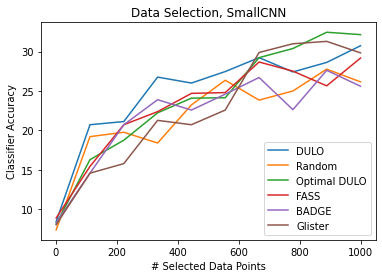

In [ ]:
plt.figure()
corruption = 'Noisy'

plt.plot(inspect_points, acc_greedy, label='DULO')
plt.plot(inspect_points, acc_random, label='Random')
plt.plot(inspect_points, acc_optimal, label='Optimal DULO')
plt.plot(inspect_points, acc_fass, label='FASS')
plt.plot(inspect_points, acc_badge, label='BADGE')
plt.plot(inspect_points, acc_glister, label='Glister')

plt.title('Visda, SmallCNN, ' + corruption)
plt.ylabel('Classifier Accuracy')
plt.xlabel('# Selected Data Points')
plt.legend()
plt.show()

## Run (finetune)

In [ ]:
rank_dict = pickle.load(open(model_dir+"/visda_rank_dict.pkl","rb"))

deepset_selected_rank = rank_dict['dulo']
random_perm = rank_dict['random']
optimal_dulo_selected_rank = rank_dict['optimal']
fass_selected_rank = rank_dict['fass'] 
badge_selected_rank = rank_dict['badge'] 
glister_selected_rank = rank_dict['glister']

print(model_dir)

/content/gdrive/My Drive//active-learning-transfer/models/cycada/visda/iter_1_32/


In [30]:
def get_da_acc(netG, netF, x_test, y_test):
  
  netG.eval()
  netF.eval()
  with torch.no_grad():
    test_dataset = TensorDataset(x_test,y_test)
    test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.cuda(), requires_grad=False)
        labels = Variable(labels.cuda(), requires_grad=False)
        s_bottleneck = netG(images)
        _, score = netF(s_bottleneck)
        pred = score.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(labels.data).cpu().sum()
        total += labels.size(0)
      
  accuracy = 100.0 * correct/total

  return accuracy / 100
  

model_dir = prefix + '/active-learning-transfer/models/cycada/visda/iter_1_32/'
load_name_G = model_dir + "/VisDA_HAFN_resnet101_netG_1.1_10.pth"
load_name_F = model_dir + "/VisDA_HAFN_resnet101_netF_1.1_10.pth"

netG = ResBase101().cuda()
netF = ResClassifier(class_num=12, extract=True).cuda()
netG.load_state_dict(torch.load(load_name_G))
netG.eval()
netF.load_state_dict(torch.load(load_name_F))
netF.eval()

da_acc = get_da_acc(netG, netF, visda_x_test_re, visda_y_test_re)
print('DA Model Accuracy: {}'.format(da_acc))

DA Model Accuracy: 0.6100000143051147


In [31]:
cluster_syn = pickle.load(open(sample_dir+'/cluster_syn_feat.data', 'rb'))

def setTrainFalse(layer):
  for i in range(4):
    layer[i].conv1.weight.trainable = False
    layer[i].conv2.weight.trainable = False



from scipy.stats import wasserstein_distance
def get_label(centroids, feat):
  best_dist = 1e9
  for k in range(len(centroids)):
    # import pdb;pdb.set_trace()
    dist = wasserstein_distance(centroids[k].detach().cpu(), feat.detach().cpu())
    if dist < best_dist:
      best_dist = dist 
      pred_label = k 
  
  return pred_label


def data_to_acc_finetune(adda_net_file, x_train, y_train, x_test, y_test, x_unlabel, verbose=0, lr=2e-6):
  netG = ResBase101().cuda()
  netF = ResClassifier(class_num=12, extract=True).cuda()
  netF.train()
  netG.load_state_dict(torch.load(adda_net_file[0]))
  netF.load_state_dict(torch.load(adda_net_file[1]))


  # net.conv1.weight.trainable = False
  # setTrainFalse(net.layer1)
  # setTrainFalse(net.layer2)
  # setTrainFalse(net.layer3)
  

  optimizer = optim.Adam(netF.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0)
  criterion = nn.CrossEntropyLoss()

  # get centriods for K classes
  masks = []
  centroids = []
  for k in range(12):
    mask = np.zeros_like(y_train, dtype=bool)
    for i in range(len(y_train)):
      mask[i] = True if y_train[i] == k else False 
    
    cluster_x = x_train[mask]
    if cluster_x.shape[0] > 1:
      centroid = featureExtract(cluster_x, netG, netF)
      centroid = torch.mean(centroid, dim=0)
    else:
      print('Unnormal Alert!')
      centroid = cluster_syn[k]

    masks.append(mask)
    centroids.append(centroid)
  
  
  # predict fake labels for unlabel data
  x_unlabel_feat = []
  for j in range(x_unlabel.shape[0]//50):
    start_ind = j*50
    batch_X, batch_y = [], []
    stop_ind = min(start_ind+50, x_unlabel.shape[0])
    feat = featureExtract(x_unlabel[start_ind:stop_ind], netG, netF)
    x_unlabel_feat.append(feat)

  x_unlabel_feat = torch.cat(x_unlabel_feat, dim=0)

  y_unlabel = []
  for i in range(x_unlabel.size(0)):
    y_unlabel.append(get_label(centroids, x_unlabel_feat[i]))

  y_unlabel = torch.tensor(y_unlabel)

  x_train_new = torch.cat((x_train, x_unlabel), dim=0)
  y_train_new = torch.cat((y_train, y_unlabel), dim=0)

  finetune_dataset = TensorDataset(x_train_new,y_train_new)
  train_loader = DataLoader(dataset=finetune_dataset, batch_size=32, shuffle=True)
  test_dataset = TensorDataset(x_test,y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

  best_acc = 0
  for epoch in range(35):
      netF.train()
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images.cuda(), requires_grad=False)
          labels = Variable(labels.cuda(), requires_grad=False)
          optimizer.zero_grad()
          # import pdb;pdb.set_trace()
          s_bottleneck = netG(images)
          _, score = netF(s_bottleneck)
          loss = criterion(score, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      test_acc = get_da_acc(netG, netF, x_test, y_test)

      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), test_acc*100.0))

      if test_acc > best_acc:
        best_acc = test_acc
      else:
        break
  print('Model Accuracy: {}'.format(best_acc*100.0))


  return best_acc


def get_unlabel(selected_rank):
  idx_unlabel = np.ones_like(visda_y_unlabel_re, dtype=bool)
  idx_unlabel[selected_rank] = False
  return visda_x_unlabel_re[idx_unlabel]

In [33]:
def data_to_acc_finetune_ori(adda_net_file, x_train, y_train, x_test, y_test, x_unlabel, verbose=0, lr=2e-6):
  netG = ResBase101().cuda()
  netF = ResClassifier(class_num=12, extract=True).cuda()
  netF.train()
  netG.load_state_dict(torch.load(adda_net_file[0]))
  netF.load_state_dict(torch.load(adda_net_file[1]))


  # net.conv1.weight.trainable = False
  # setTrainFalse(net.layer1)
  # setTrainFalse(net.layer2)
  # setTrainFalse(net.layer3)
  

  optimizer = optim.Adam(netF.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0)
  criterion = nn.CrossEntropyLoss()

  finetune_dataset = TensorDataset(x_train,y_train)
  train_loader = DataLoader(dataset=finetune_dataset, batch_size=32, shuffle=True)
  test_dataset = TensorDataset(x_test,y_test)
  test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

  best_acc = 0
  for epoch in range(35):
      netF.train()
      for i, (images, labels) in enumerate(train_loader):
          images = Variable(images.cuda(), requires_grad=False)
          labels = Variable(labels.cuda(), requires_grad=False)
          optimizer.zero_grad()
          # import pdb;pdb.set_trace()
          s_bottleneck = netG(images)
          _, score = netF(s_bottleneck)
          loss = criterion(score, labels)
          loss.backward()
          optimizer.step()
      correct = 0
      total = 0
      test_acc = get_da_acc(netG, netF, x_test, y_test)

      if verbose:
        print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), test_acc*100.0))

      if test_acc > best_acc:
        best_acc = test_acc
      else:
        break
  print('Model Accuracy: {}'.format(best_acc*100.0))


  return best_acc


##### Get centriods of SYN

In [ ]:
# get centriods of SYN
masks = []
cluster_syn = []
for k in range(12):
  mask = np.zeros_like(y_train_few_re, dtype=bool)
  for i in range(len(y_train_few_re)):
    mask[i] = True if y_train_few_re[i] == k else False 
  
  cluster_x = x_train_few_re[mask]
  if cluster_x.shape[0] > 1:
    centroid = featureExtract(cluster_x, netG, netF)
    centroid = torch.mean(centroid, dim=0)
  else:
    print('Unnormal Alert!')

  masks.append(mask)
  cluster_syn.append(centroid)

In [ ]:
print(len(cluster_syn))
print(cluster_syn[0].shape)
pickle.dump(cluster_syn, open(sample_dir+'/cluster_syn_feat.data', 'wb'))

12
torch.Size([1000])


In [ ]:
cluster_syn = pickle.load(open(sample_dir+'/cluster_syn_feat.data', 'rb'))

In [ ]:
adda_file = [model_dir + "/VisDA_HAFN_resnet101_netG_1.1_10.pth", model_dir+"/VisDA_HAFN_resnet101_netF_1.1_10.pth"]

acc_greedy_ft = [da_acc]
acc_random_ft = [da_acc]
acc_optimal_ft = [da_acc]
acc_ds = [da_acc]

inspect_points = np.linspace(100, 1000, num=10).astype(int)

random_perm = rank_dict['random']


for i in inspect_points:
  acc_ds.append(da_acc)
  acc_greedy_ft.append(data_to_acc_finetune(adda_file, visda_x_unlabel_re[deepset_selected_rank[:i]], visda_y_unlabel_re[deepset_selected_rank[:i]], visda_x_test_re, visda_y_test_re, get_unlabel(deepset_selected_rank[:i])[:i]))
  # import pdb;pdb.set_trace()

  acc_random_ft.append(data_to_acc_finetune(adda_file, visda_x_unlabel_re[random_perm[:i]], visda_y_unlabel_re[random_perm[:i]], visda_x_test_re, visda_y_test_re, get_unlabel(random_perm[:i][:i])))

  acc_optimal_ft.append(data_to_acc_finetune(adda_file, visda_x_unlabel_re[optimal_dulo_selected_rank[:i]], visda_y_unlabel_re[optimal_dulo_selected_rank[:i]], visda_x_test_re, visda_y_test_re, get_unlabel(optimal_dulo_selected_rank[:i])[:i]))

Unnormal Alert!
Model Accuracy: 70.0
Unnormal Alert!
Model Accuracy: 77.0999984741211
Unnormal Alert!
Unnormal Alert!
Model Accuracy: 70.30000305175781
Model Accuracy: 67.3499984741211
Model Accuracy: 78.05000305175781
Model Accuracy: 69.0999984741211
Model Accuracy: 64.4000015258789
Model Accuracy: 77.5
Model Accuracy: 68.4000015258789
Model Accuracy: 65.0
Model Accuracy: 76.69999694824219
Model Accuracy: 72.1500015258789
Model Accuracy: 68.0999984741211
Model Accuracy: 76.94999694824219
Model Accuracy: 73.80000305175781
Model Accuracy: 73.5999984741211
Model Accuracy: 76.55000305175781
Model Accuracy: 76.0
Model Accuracy: 75.9000015258789
Model Accuracy: 77.0
Model Accuracy: 76.1500015258789
Model Accuracy: 75.5999984741211
Model Accuracy: 77.25
Model Accuracy: 76.6500015258789
Model Accuracy: 77.5
Model Accuracy: 76.5999984741211
Model Accuracy: 77.19999694824219
Model Accuracy: 76.55000305175781
Model Accuracy: 77.44999694824219
Model Accuracy: 76.1500015258789


In [ ]:
acc_fass_ft = [da_acc]
acc_badge_ft = [da_acc]
acc_glister_ft = [da_acc]


for i in inspect_points:
  acc_fass_ft.append(data_to_acc_finetune(adda_file, visda_x_unlabel_re[fass_selected_rank[:i]], visda_y_unlabel_re[fass_selected_rank[:i]], visda_x_test_re, visda_y_test_re, get_unlabel(fass_selected_rank[:i])[:i]))
  
  acc_badge_ft.append(data_to_acc_finetune(adda_file, visda_x_unlabel_re[badge_selected_rank[:i]], visda_y_unlabel_re[badge_selected_rank[:i]], visda_x_test_re, visda_y_test_re, get_unlabel(badge_selected_rank[:i])[:i]))

  acc_glister_ft.append(data_to_acc_finetune(adda_file, visda_x_unlabel_re[glister_selected_rank[:i]], visda_y_unlabel_re[glister_selected_rank[:i]], visda_x_test_re, visda_y_test_re, get_unlabel(glister_selected_rank[:i])[:i]))

Unnormal Alert!
Unnormal Alert!
Unnormal Alert!
Unnormal Alert!
Unnormal Alert!
Unnormal Alert!
Model Accuracy: 66.5999984741211
Model Accuracy: 71.25
Unnormal Alert!
Model Accuracy: 70.55000305175781
Unnormal Alert!
Model Accuracy: 66.69999694824219
Model Accuracy: 68.3499984741211
Model Accuracy: 68.05000305175781
Model Accuracy: 65.05000305175781
Model Accuracy: 67.25
Model Accuracy: 66.3499984741211
Model Accuracy: 65.5
Model Accuracy: 65.8499984741211
Model Accuracy: 69.19999694824219
Model Accuracy: 69.6500015258789
Model Accuracy: 70.75
Model Accuracy: 71.1500015258789
Model Accuracy: 74.5
Model Accuracy: 75.69999694824219
Model Accuracy: 74.44999694824219
Model Accuracy: 75.5
Model Accuracy: 75.05000305175781
Model Accuracy: 75.80000305175781
Model Accuracy: 76.44999694824219
Model Accuracy: 76.44999694824219
Model Accuracy: 75.9000015258789
Model Accuracy: 77.55000305175781
Model Accuracy: 77.69999694824219
Model Accuracy: 76.3499984741211
Model Accuracy: 77.25
Model Accuracy:

### Plot

In [ ]:
# check noisy
inspect_points = np.linspace(100, target_size, num=10).astype(int)
noise_cnt = []
for i in inspect_points:
  cnt = sum(x < 1700 for x in deepset_selected_rank[:i])
  noise_cnt.append(cnt)

print(inspect_points)
print(noise_cnt)

In [ ]:
acc_dict = {}

acc_dict['dulo'] = acc_greedy_ft
acc_dict['random'] = acc_random_ft
acc_dict['optimal'] = acc_optimal_ft
acc_dict['fass'] = acc_fass_ft
acc_dict['badge'] = acc_badge_ft
acc_dict['glister'] = acc_glister_ft

print(model_dir)
pickle.dump(acc_dict, open(model_dir+'accFinetune_dict_lessunlabel.pkl',"wb"))

/content/gdrive/My Drive//active-learning-transfer/models/cycada/visda/iter_1_32/


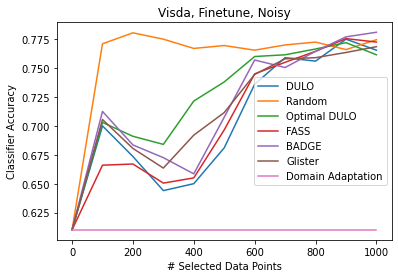

In [ ]:



inspect_points = np.linspace(0, target_size, num=11).astype(int)
corruption = 'Noisy'
plt.figure()
plt.plot(inspect_points, acc_greedy_ft, label='DULO')
plt.plot(inspect_points, acc_random_ft, label='Random')
plt.plot(inspect_points, acc_optimal_ft, label='Optimal DULO')
plt.plot(inspect_points, acc_fass_ft, label='FASS')
plt.plot(inspect_points, acc_badge_ft, label='BADGE')
plt.plot(inspect_points, acc_glister_ft, label='Glister')
plt.plot(inspect_points, acc_ds, label='Domain Adaptation')

plt.title('Visda, Finetune, ' + corruption)
plt.ylabel('Classifier Accuracy')
plt.xlabel('# Selected Data Points')
plt.legend()
plt.show()

## Multi seed

In [ ]:
acc_dulo_dict = {}
acc_random_dict = {}
acc_optimal_dict = {}
acc_fass_dict = {}
acc_badge_dict = {}
acc_glister_dict = {}

rank_dulo_dict = {}
rank_random_dict = {}
rank_optimal_dict = {}
rank_fass_dict = {}
rank_badge_dict = {}
rank_glister_dict = {}

net = torch_cifar_logistic_data_to_net(x_train_few, y_train_few, x_val_few, y_val_few)

for seed in range(12, 18):
  _, deepset_selected_rank, _ = findMostValuableSample_deepset_stochasticgreedy(model.model, visda_x_unlabel_resNetFeature, target_size, epsilon=1e-4, seed=seed)
  random_perm = np.random.permutation(range(unlabel_size))
  _, optimal_dulo_selected_rank, _ = findMostValuableSample_deepset_stochasticgreedy(model_optimal.model, visda_x_unlabel_resNetFeature, target_size, epsilon=1e-4, seed=seed)

  
  strategy_args = {'batch_size':target_size, 'submod':'facility_location', 'selection_type':'PerClass'}
  strategy = FASS(x_train_few, y_train_few, visda_x_unlabel_few_re.numpy(), net.cuda(), DataHandler_Points, 10, strategy_args)
  fass_selected_rank = strategy.select(target_size)

  strategy_args = {'batch_size' : target_size}
  strategy = BADGE(x_train_few, y_train_few, visda_x_unlabel_few_re.numpy(), net.cuda(), DataHandler_Points, 10, strategy_args)
  badge_selected_rank = strategy.select(target_size)

  strategy_args = {'batch_size' : target_size, 'lr':float(0.001)}
  strategy = glister.GLISTER(x_train_few, y_train_few, visda_x_unlabel_few_re.numpy(), net.cuda(), DataHandler_Points, 10, strategy_args, 
                            valid=True, X_val=x_val_few, Y_val=y_val_few)
  glister_selected_rank = strategy.select(target_size)



  rank_dulo_dict[seed] = deepset_selected_rank
  rank_random_dict[seed] = random_perm
  rank_optimal_dict[seed] = optimal_dulo_selected_rank
  rank_fass_dict[seed] = fass_selected_rank
  rank_badge_dict[seed] = badge_selected_rank
  rank_glister_dict[seed] = glister_selected_rank


  acc_greedy = []
  acc_random = []
  acc_optimal = []
  acc_fass = []
  acc_badge = []
  acc_glister = []

  inspect_points = np.linspace(1, target_size, num=10).astype(int)

  for i in inspect_points:
    acc_greedy.append(torch_stl_smallcnn_data_to_acc(visda_x_unlabel_few[deepset_selected_rank[:i]], visda_y_unlabel_few[deepset_selected_rank[:i]], visda_x_test, visda_y_test))
    acc_random.append(torch_stl_smallcnn_data_to_acc(visda_x_unlabel_few[random_perm[:i]], visda_y_unlabel_few[random_perm[:i]], visda_x_test, visda_y_test))
    acc_optimal.append(torch_stl_smallcnn_data_to_acc(visda_x_unlabel_few[optimal_dulo_selected_rank[:i]], visda_y_unlabel_few[optimal_dulo_selected_rank[:i]], visda_x_test, visda_y_test) )

    acc_fass.append(torch_stl_smallcnn_data_to_acc(visda_x_unlabel_few[fass_selected_rank[:i]], visda_y_unlabel_few[fass_selected_rank[:i]], visda_x_test, visda_y_test))
    acc_badge.append(torch_stl_smallcnn_data_to_acc(visda_x_unlabel_few[badge_selected_rank[:i]], visda_y_unlabel_few[badge_selected_rank[:i]], visda_x_test, visda_y_test))
    acc_glister.append(torch_stl_smallcnn_data_to_acc(visda_x_unlabel_few[glister_selected_rank[:i]], visda_y_unlabel_few[glister_selected_rank[:i]], visda_x_test, visda_y_test))
    

  acc_dulo_dict[seed] = acc_greedy
  acc_random_dict[seed] = acc_random
  acc_optimal_dict[seed] = acc_optimal
  acc_fass_dict[seed] = acc_fass
  acc_badge_dict[seed] = acc_badge
  acc_glister_dict[seed] = acc_glister

Sample Size R=18
Sample Size R=18


/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating a

Sample Size R=18
Sample Size R=18


/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating a

Sample Size R=18
Sample Size R=18


/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating a

Sample Size R=18
Sample Size R=18


/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating a

Sample Size R=18
Sample Size R=18


/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating a

Sample Size R=18
Sample Size R=18


/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  [list(BatchSampler(SequentialSampler(np.arange(len(y_temp))), self.batch_size, drop_last=False))][0])
/usr/local/lib/python3.7/dist-packages/distil/utils/similarity_mat.py:112: VisibleDeprecationWarning: Creating a

### load rank and acc

In [32]:
corruption = 'Noisy'
model_dir = prefix + '/active-learning-transfer/models/cycada/visda/iter_1_32/'

rank_dulo_dict, rank_random_dict, rank_optimal_dict, rank_fass_dict, rank_badge_dict, rank_glister_dict = pickle.load(open("./rank_12_18_{}.pkl".format(corruption),"rb"))
acc_dulo_dict, acc_random_dict, acc_optimal_dict, acc_fass_dict, acc_badge_dict, acc_glister_dict = pickle.load(open("./acc_12_18_{}.pkl".format(corruption),"rb"))

### plot

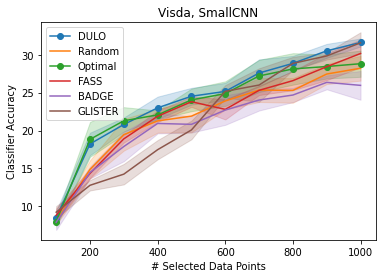

In [ ]:
target_size = 1000

inspect_points = np.linspace(100, target_size, num=10).astype(int)

acc_dulo = np.zeros((6, 10))
acc_random = np.zeros((6, 10))
acc_optimal = np.zeros((6, 10))
acc_fass = np.zeros((6, 10))
acc_badge = np.zeros((6, 10))
acc_glister = np.zeros((6, 10))

for i in range(6):
  seed = i+12
  acc_dulo[i] = acc_dulo_dict[seed]
  acc_random[i] = acc_random_dict[seed]
  acc_optimal[i] = acc_optimal_dict[seed]
  acc_fass[i] = acc_fass_dict[seed]
  acc_badge[i] = acc_badge_dict[seed]
  acc_glister[i] = acc_glister_dict[seed]

plt.figure()

def plot_fill(record, name, col):
  if name in ['DULO', 'Optimal']:
    plt.plot(inspect_points, np.mean(record, axis=0), label=name, color=col, marker='o')
  else:
    plt.plot(inspect_points, np.mean(record, axis=0), label=name, color=col)
  plt.fill_between(inspect_points, np.mean(record, axis=0)+np.std(record, axis=0), np.mean(record, axis=0)-np.std(record, axis=0), alpha=0.2, color=col)

plot_fill(acc_dulo, 'DULO', 'C0')
plot_fill(acc_random, 'Random', 'C1')
plot_fill(acc_optimal, 'Optimal', 'C2')
plot_fill(acc_fass, 'FASS', 'C3')
plot_fill(acc_badge, 'BADGE', 'C4')
plot_fill(acc_glister, 'GLISTER', 'C5')

plt.title('Visda, SmallCNN') 
plt.ylabel('Classifier Accuracy')
plt.xlabel('# Selected Data Points')
plt.legend()
plt.show()

In [ ]:
print(corruption)

Noisy


In [ ]:
model_dir = prefix + '/active-learning-transfer/models/cycada/cifar_to_stl_uda'

pickle.dump([rank_dulo_dict, rank_random_dict, rank_optimal_dict, rank_fass_dict, rank_badge_dict, rank_glister_dict], open(model_dir+"/rank_12_18_{}.pkl".format(corruption),"wb"))
pickle.dump([acc_dulo_dict, acc_random_dict, acc_optimal_dict, acc_fass_dict, acc_badge_dict, acc_glister_dict], open(model_dir+"/acc_12_18_{}.pkl".format(corruption),"wb"))

In [ ]:
print(model_dir)

/content/gdrive/My Drive//active-learning-transfer/models/cycada/usps_to_mnist/iter_1_28_noisy0.5


## Multi seed (fine-tune)

In [ ]:
def check_selection_unnormal(set_selected):
  # input is torch tensor
  for i in range(10):
    if i in set_selected:
      continue
    else:
      return True
  return False


In [ ]:
corruption = 'Noisy'


acc_dulo_dict_ft = {}
acc_random_dict_ft = {}
acc_optimal_dict_ft = {}
acc_fass_dict_ft = {}
acc_badge_dict_ft = {}
acc_glister_dict_ft = {}

rank_dulo_dict, rank_random_dict, rank_optimal_dict, rank_fass_dict, rank_badge_dict, rank_glister_dict = pickle.load(open(model_dir+"/rank_12_18_{}.pkl".format(corruption),"rb"))

adda_file = [model_dir + "/VisDA_HAFN_resnet101_netG_1.1_10.pth", model_dir+"/VisDA_HAFN_resnet101_netF_1.1_10.pth"]


for seed in range(12, 18):

  deepset_selected_rank = rank_dulo_dict[seed]
  random_perm = rank_random_dict[seed]
  optimal_dulo_selected_rank = rank_optimal_dict[seed]
  fass_selected_rank = rank_fass_dict[seed]
  badge_selected_rank = rank_badge_dict[seed] 
  glister_selected_rank = rank_glister_dict[seed]

  
  acc_greedy_ft = [da_acc]
  acc_random_ft = [da_acc]
  acc_optimal_ft = [da_acc]
  acc_fass_ft  = [da_acc]
  acc_badge_ft = [da_acc]
  acc_glister_ft = [da_acc]

  inspect_points = np.linspace(100, 1000, num=10).astype(int)

  for i in inspect_points:
    print(i)

    
    acc_greedy_ft.append(data_to_acc_finetune_ori(adda_file, visda_x_unlabel_re[deepset_selected_rank[:i]], visda_y_unlabel_re[deepset_selected_rank[:i]], visda_x_test_re, visda_y_test_re, get_unlabel(deepset_selected_rank[:i])))

    acc_random_ft.append(data_to_acc_finetune_ori(adda_file, visda_x_unlabel_re[random_perm[:i]], visda_y_unlabel_re[random_perm[:i]], visda_x_test_re, visda_y_test_re,get_unlabel(random_perm[:i])))

    acc_optimal_ft.append(data_to_acc_finetune_ori(adda_file, visda_x_unlabel_re[optimal_dulo_selected_rank[:i]], visda_y_unlabel_re[optimal_dulo_selected_rank[:i]], visda_x_test_re, visda_y_test_re, get_unlabel(optimal_dulo_selected_rank[:i])))

  
    acc_fass_ft.append(data_to_acc_finetune_ori(adda_file, visda_x_unlabel_re[fass_selected_rank[:i]], visda_y_unlabel_re[fass_selected_rank[:i]], visda_x_test_re, visda_y_test_re,get_unlabel(fass_selected_rank[:i])))
  
    acc_badge_ft.append(data_to_acc_finetune_ori(adda_file, visda_x_unlabel_re[badge_selected_rank[:i]], visda_y_unlabel_re[badge_selected_rank[:i]], visda_x_test_re, visda_y_test_re, get_unlabel(badge_selected_rank[:i])))
  
    acc_glister_ft.append(data_to_acc_finetune_ori(adda_file, visda_x_unlabel_re[glister_selected_rank[:i]], visda_y_unlabel_re[glister_selected_rank[:i]], visda_x_test_re, visda_y_test_re, get_unlabel(glister_selected_rank[:i])))


  acc_dulo_dict_ft[seed] = acc_greedy_ft
  acc_random_dict_ft[seed] = acc_random_ft
  acc_optimal_dict_ft[seed] = acc_optimal_ft
  acc_fass_dict_ft[seed] = acc_fass_ft
  acc_badge_dict_ft[seed] = acc_badge_ft
  acc_glister_dict_ft[seed] = acc_glister_ft

100
Model Accuracy: 67.30000305175781
Model Accuracy: 68.44999694824219
Model Accuracy: 69.0
Model Accuracy: 66.44999694824219
Model Accuracy: 69.6500015258789
Model Accuracy: 69.5
200
Model Accuracy: 68.6500015258789
Model Accuracy: 72.19999694824219
Model Accuracy: 71.55000305175781
Model Accuracy: 69.80000305175781
Model Accuracy: 71.05000305175781
Model Accuracy: 70.69999694824219
300
Model Accuracy: 70.69999694824219
Model Accuracy: 72.94999694824219
Model Accuracy: 73.4000015258789
Model Accuracy: 70.19999694824219
Model Accuracy: 72.5999984741211
Model Accuracy: 72.94999694824219
400
Model Accuracy: 70.69999694824219
Model Accuracy: 73.0
Model Accuracy: 74.75
Model Accuracy: 70.0
Model Accuracy: 73.3499984741211
Model Accuracy: 73.0999984741211
500
Model Accuracy: 71.5
Model Accuracy: 75.25
Model Accuracy: 75.80000305175781
Model Accuracy: 68.5999984741211
Model Accuracy: 75.1500015258789
Model Accuracy: 74.9000015258789
600
Model Accuracy: 72.19999694824219
Model Accuracy: 74.0

### load rank and acc

In [ ]:
corruption = 'Noisy'
model_dir = prefix + '/active-learning-transfer/models/cycada/visda/iter_1_32/'


rank_dulo_dict, rank_random_dict, rank_optimal_dict, rank_fass_dict, rank_badge_dict, rank_glister_dict = pickle.load(open(model_dir+"/rank_12_18_{}.pkl".format(corruption),"rb"))
acc_dulo_dict_ft, acc_random_dict_ft, acc_optimal_dict_ft, acc_fass_dict_ft, acc_badge_dict_ft, acc_glister_dict_ft = pickle.load(open(model_dir+"/accFineTune_12_18_{}.pkl".format(corruption),"rb"))

FileNotFoundError: ignored

### Plot

In [ ]:
target_size = 1000
inspect_points = np.linspace(0, target_size, num=11).astype(int)


acc_dulo = np.zeros((6, 11))
acc_random = np.zeros((6, 11))
acc_optimal = np.zeros((6, 11))
acc_fass = np.zeros((6, 11))
acc_badge = np.zeros((6, 11))
acc_glister = np.zeros((6, 11))

for i in range(6):
  seed = i+12
  acc_dulo[i] = acc_dulo_dict_ft[seed]
  acc_random[i] = acc_random_dict_ft[seed]
  acc_optimal[i] = acc_optimal_dict_ft[seed]
  acc_fass[i] = acc_fass_dict_ft[seed]
  acc_badge[i] = acc_badge_dict_ft[seed]
  acc_glister[i] = acc_glister_dict_ft[seed]

plt.figure()

def plot_fill(record, name, col):
  if name in ['DULO', 'Optimal']:
    plt.plot(inspect_points, np.mean(record, axis=0), label=name, color=col, marker='o')
  else:
    plt.plot(inspect_points, np.mean(record, axis=0), label=name, color=col)
  plt.fill_between(inspect_points, np.mean(record, axis=0)+np.std(record, axis=0), np.mean(record, axis=0)-np.std(record, axis=0), alpha=0.2, color=col)

plot_fill(acc_dulo, 'DULO', 'C0')
plot_fill(acc_random, 'Random', 'C1')
plot_fill(acc_optimal, 'Optimal', 'C2')
plot_fill(acc_fass, 'FASS', 'C3')
plot_fill(acc_badge, 'BADGE', 'C4')
plot_fill(acc_glister, 'GLISTER', 'C5')

plt.title('Visda, Finetune')
plt.ylabel('Classifier Accuracy')
plt.xlabel('# Selected Data Points')
plt.legend()
plt.show()

In [ ]:
print(corruption)

Noisy


In [ ]:
pickle.dump([acc_dulo_dict_ft, acc_random_dict_ft, acc_optimal_dict_ft, acc_fass_dict_ft, acc_badge_dict_ft, acc_glister_dict_ft], open(model_dir+"/accFineTuneori_12_18_{}.pkl".format(corruption),"wb"))

In [ ]:
print(model_dir)

/content/gdrive/My Drive//active-learning-transfer/models/cycada/ds/iter_1_28_noise


## MULT

In [ ]:
model_dir = prefix + '/active-learning-transfer/models/cycada/visda/iter_1_32'

# deepset_rank_coll, random_rank_coll, optimal_rank_coll, fass_rank_coll, badge_rank_coll, glister_rank_coll = pickle.load(open(model_dir+"/visda_new.acccoll","rb"))
acc_coll, ftacc_coll = pickle.load(open(model_dir+"/visda_new.acccoll","rb"))

In [ ]:
target_size = 5000
interval = 500
inspect_points = np.linspace(interval, target_size, num=int(target_size/interval)).astype(int)
print(inspect_points)

[ 500 1000 1500 2000 2500 3000 3500 4000 4500 5000]


In [ ]:
print(len(acc_coll['deepset']))

3


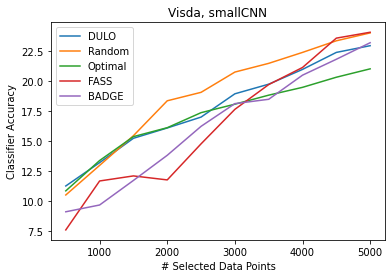

In [ ]:
target_size = 5000
interval = 500
num= int(target_size/interval)
inspect_points = np.linspace(interval, target_size, num=num).astype(int)


acc_dulo = np.zeros((6, num))
acc_random = np.zeros((6, num))
acc_optimal = np.zeros((6, num))
acc_fass = np.zeros((6, num))
acc_badge = np.zeros((6, num))
# acc_glister = np.zeros((6, num))

for i in range(3):
  acc_dulo[i] = acc_coll['deepset'][i]
  acc_random[i] = acc_coll['random'][i]
  acc_optimal[i] = acc_coll['optimal'][i]
  acc_fass[i] = acc_coll['fass'][i]
  acc_badge[i] = acc_coll['badge'][i]
  # acc_glister[i] = acc_coll['glister'][i]

plt.figure()

def plot_fill(record, name, col):
  plt.plot(inspect_points, np.mean(record, axis=0), label=name, color=col)
  # plt.fill_between(inspect_points, np.mean(record, axis=0)+np.std(record, axis=0), np.mean(record, axis=0)-np.std(record, axis=0), alpha=0.2, color=col)

plot_fill(acc_dulo, 'DULO', 'C0')
plot_fill(acc_random, 'Random', 'C1')
plot_fill(acc_optimal, 'Optimal', 'C2')
plot_fill(acc_fass, 'FASS', 'C3')
plot_fill(acc_badge, 'BADGE', 'C4')
# plot_fill(acc_glister, 'GLISTER', 'C5')

plt.title('Visda, smallCNN')
plt.ylabel('Classifier Accuracy')
plt.xlabel('# Selected Data Points')
plt.legend()
plt.show()

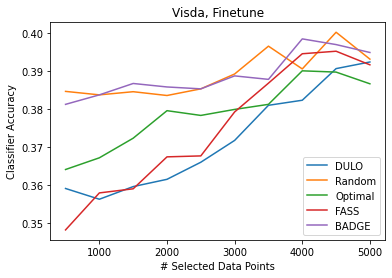

In [ ]:
target_size = 5000
interval = 500
num= int(target_size/interval)
inspect_points = np.linspace(interval, target_size, num=num).astype(int)


acc_dulo = np.zeros((6, num))
acc_random = np.zeros((6, num))
acc_optimal = np.zeros((6, num))
acc_fass = np.zeros((6, num))
acc_badge = np.zeros((6, num))
# acc_glister = np.zeros((6, num))

for i in range(3):
  acc_dulo[i] = ftacc_coll['deepset'][i]
  acc_random[i] = ftacc_coll['random'][i]
  acc_optimal[i] = ftacc_coll['optimal'][i]
  acc_fass[i] = ftacc_coll['fass'][i]
  acc_badge[i] = ftacc_coll['badge'][i]
  # acc_glister[i] = ftacc_coll['glister'][i]

plt.figure()

def plot_fill(record, name, col):
  plt.plot(inspect_points, np.mean(record, axis=0), label=name, color=col)
  # plt.fill_between(inspect_points, np.mean(record, axis=0)+np.std(record, axis=0), np.mean(record, axis=0)-np.std(record, axis=0), alpha=0.2, color=col)

plot_fill(acc_dulo, 'DULO', 'C0')
plot_fill(acc_random, 'Random', 'C1')
plot_fill(acc_optimal, 'Optimal', 'C2')
plot_fill(acc_fass, 'FASS', 'C3')
plot_fill(acc_badge, 'BADGE', 'C4')
# plot_fill(acc_glister, 'GLISTER', 'C5')

plt.title('Visda, Finetune')
plt.ylabel('Classifier Accuracy')
plt.xlabel('# Selected Data Points')
plt.legend()
plt.show()